In [1]:
import gym
import time
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [6]:
print(list(gym.envs.registry.keys()))

['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4']


# Taxi-v3

## Exploration

The observation space: Discrete(500)
The action space: Discrete(6)


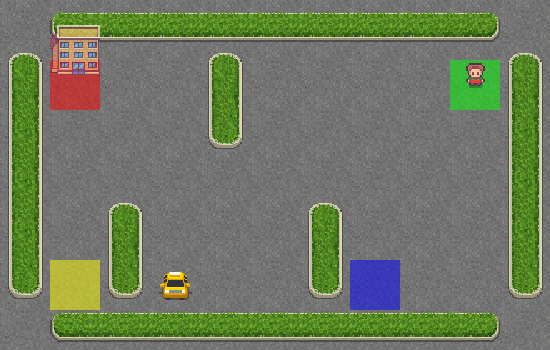

In [19]:
env = gym.make('Taxi-v3', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") # state size
# 6 actions: up / down / left / right / pick-up / drop-off
print(f"The action space: {env.action_space}") 

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img

In [8]:
# Reset environment to initial state
env = gym.make('Taxi-v3', render_mode="human")
obs = env.reset()

for _ in range(10):
    # Select a random action
    action = env.action_space.sample()

    # Apply the action to the environment
    obs, reward, terminated, truncated, info = env.step(action)

    # break when terminated or truncated 
    if terminated or truncated:
        break

    # Render the environment
    env.render()
    
    # add delay
    time.sleep(0.05)

env.close()

## DQN Agent

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
import os
import time

In [24]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [49]:
class DQNAgent:
    def __init__(self, state_size, action_size,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, batch_size=64, lr=0.001, mem_size=2000):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.memory = deque(maxlen=mem_size)  # experience replay memory
        self.model = DQN(state_size, action_size).float()
        self.target_model = DQN(state_size, action_size).float()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def act(self, state, test=False):
        if not test:
            # Epsilon-greedy strategy
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
        state = self._to_one_hot(state)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample a batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.cat([self._to_one_hot(s) for s in states])
        next_states = torch.cat([self._to_one_hot(s) for s in next_states])
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Get current Q-values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute Q-targets
        with torch.no_grad():
            target_q_values = self.target_model(next_states)
        next_q_values = target_q_values.max(1)[0]
        targets = rewards + (self.gamma * next_q_values * (1 - dones))
        
        
        # Loss function
        loss = nn.MSELoss()(current_q_values, targets)
        
        # Backpropagate and optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def _to_one_hot(self, state):
        """
        convert discrete state to one-hot
        """
        return F.one_hot(torch.tensor(state), num_classes=self.state_size).float().unsqueeze(0)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def save_model(self, filepath='../models/dqn_taxi_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")
        
    def load_model(self, filepath='../models/dqn_taxi_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model.load_state_dict(torch.load(filepath))
        self.model.eval()  # Set the model to evaluation mode
        print(f"Model loaded from {filepath}")

In [23]:
env = gym.make('Taxi-v3')
state_size = env.observation_space.n
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

## Training

In [39]:
def train(agent, env, episodes=800, max_timesteps=200, k=20, update_freq=10):
    episode_rewards = []
    
    for e in range(episodes):
        state, info = env.reset()
        total_reward = 0
        
        for t in range(max_timesteps):     
            # Choose action
            action = agent.act(state)
            
            # Take the action and observe the result
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Remember the experience
            agent.remember(state, action, reward, next_state, done)

            # Train the agent
            agent.replay()
            
            # Update the state and accumulate the reward
            state = next_state
            total_reward += reward
            
            if done:
                if (e + 1) % 50 == 0 or e == 0:
                    print(f"Episode {e+1}/{episodes} finished with epsilon {agent.epsilon:.2} and mean reward {sum(episode_rewards[-k:])/k}")
                break
        
        # Update target model after 10 eps
        if e % update_freq == 0:
            agent.update_target_model()
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Store the total reward for the episode
        episode_rewards.append(total_reward)

    env.close()
    return episode_rewards

In [101]:
# Run the training
hist = train(agent, env)

Episode 1/800 finished with reward -812
Episode 50/800 finished with reward -731
Episode 100/800 finished with reward -551
Episode 150/800 finished with reward -533
Episode 200/800 finished with reward -251
Episode 250/800 finished with reward -425
Episode 300/800 finished with reward -255
Episode 350/800 finished with reward -272
Episode 400/800 finished with reward -245
Episode 450/800 finished with reward -272
Episode 500/800 finished with reward -281
Episode 550/800 finished with reward -113
Episode 600/800 finished with reward -218
Episode 650/800 finished with reward -43
Episode 700/800 finished with reward -200
Episode 750/800 finished with reward -209
Episode 800/800 finished with reward -200


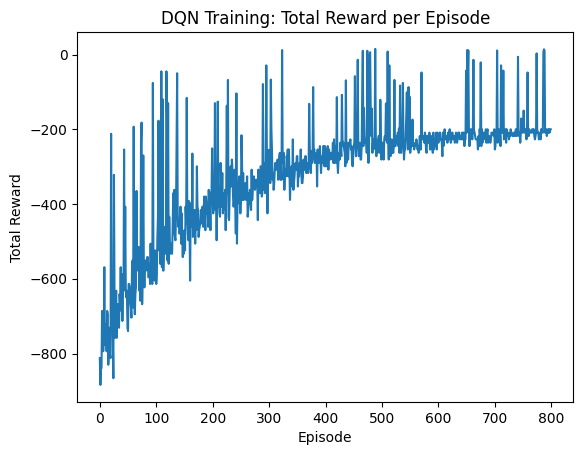

In [102]:
# Plotting the rewards with matplotlib
plt.plot(hist)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training: Total Reward per Episode')
plt.show()

In [107]:
agent.save_model()

Model saved to ../models/dqn_taxi_model.pth


## Testing

In [26]:
agent.load_model()

Model loaded from ../models/dqn_taxi_model.pth


In [7]:
import pygame

def test(agent, env, episodes=10, max_timesteps=200):
    pygame.init()
    clock = pygame.time.Clock()
    try:
        for e in range(episodes):
            state, info = env.reset()  # Reset the environment and get initial state
            total_reward = 0
            
            for t in range(max_timesteps): 
                # Choose the best action according to the trained agent 
                action = agent.act(state, test=True)
                
                # Take the action and observe the result
                next_state, reward, terminated, truncated, info = env.step(action)
                if terminated or truncated:
                    break
                
                # Update the state and accumulate the reward
                state = next_state
                total_reward += reward
    
                # render screen
                env.render()

                # pygame events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        return
                
                # add delay
                time.sleep(0.05)
                # frame rate
                clock.tick(15)
            
            print(f"Episode {e+1}/{episodes} finished with total reward: {total_reward}")
    finally:
        env.close()
        pygame.quit()

In [30]:
env = gym.make('Taxi-v3', render_mode="human")
test(agent, env)

Episode 1/10 finished with total reward: -199
Episode 2/10 finished with total reward: -199
Episode 3/10 finished with total reward: -199
Episode 4/10 finished with total reward: -199


# Frozen Lake

In [99]:
class DQN2(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN2, self).__init__()
        self.fc1 = nn.Linear(state_size, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

class DQNAgent2:
    def __init__(self, state_size, action_size,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, batch_size=32, lr=5e-4, mem_size=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.memory = deque(maxlen=mem_size)  # experience replay memory
        self.model = DQN2(state_size, action_size).float()
        self.target_model = DQN2(state_size, action_size).float()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def act(self, state, test=False):
        if not test:
            # Epsilon-greedy strategy
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
        state = self._to_one_hot(state)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample a batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.cat([self._to_one_hot(s) for s in states])
        next_states = torch.cat([self._to_one_hot(s) for s in next_states])
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Get current Q-values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute Q-targets
        with torch.no_grad():
            target_q_values = self.target_model(next_states)
        next_q_values = target_q_values.max(1)[0]
        targets = rewards + (self.gamma * next_q_values * (1 - dones))
        
        
        # Loss function
        loss = nn.MSELoss()(current_q_values, targets)
        
        # Backpropagate and optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5)
        self.optimizer.step()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def _to_one_hot(self, state):
        """
        convert discrete state to one-hot
        """
        return F.one_hot(torch.tensor(state), num_classes=self.state_size).float().unsqueeze(0)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def save_model(self, filepath='../models/dqn_taxi_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")
        
    def load_model(self, filepath='../models/dqn_taxi_model.pth'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model.load_state_dict(torch.load(filepath))
        self.model.eval()  # Set the model to evaluation mode
        print(f"Model loaded from {filepath}")

The observation space: Discrete(16)
The action space: Discrete(4)


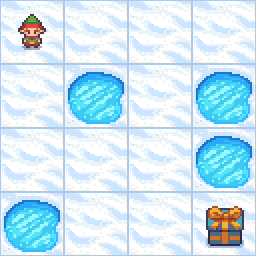

In [8]:
# FrozenLake8x8-v1 / FrozenLake-v1
env = gym.make('FrozenLake-v1', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") # state size
print(f"The action space: {env.action_space}") # Up / Down / Left / Right

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img

In [100]:
env = gym.make('FrozenLake-v1') 
state_size = env.observation_space.n
action_size = env.action_space.n
agent = DQNAgent2(state_size, action_size)

In [101]:
env = gym.make('FrozenLake-v1') 
hist = train(agent, env, episodes=2500, max_timesteps=100)

Episode 1/2500 finished with epsilon 1.0 and mean reward 0.0
Episode 50/2500 finished with epsilon 0.78 and mean reward 0.0
Episode 100/2500 finished with epsilon 0.61 and mean reward 0.0
Episode 150/2500 finished with epsilon 0.47 and mean reward 0.0
Episode 200/2500 finished with epsilon 0.37 and mean reward 0.0
Episode 250/2500 finished with epsilon 0.29 and mean reward 0.0
Episode 300/2500 finished with epsilon 0.22 and mean reward 0.0
Episode 350/2500 finished with epsilon 0.17 and mean reward 0.1
Episode 400/2500 finished with epsilon 0.14 and mean reward 0.2
Episode 450/2500 finished with epsilon 0.11 and mean reward 0.35
Episode 500/2500 finished with epsilon 0.082 and mean reward 0.45
Episode 550/2500 finished with epsilon 0.064 and mean reward 0.45
Episode 600/2500 finished with epsilon 0.05 and mean reward 0.55
Episode 650/2500 finished with epsilon 0.039 and mean reward 0.6
Episode 700/2500 finished with epsilon 0.03 and mean reward 0.7
Episode 750/2500 finished with epsilo

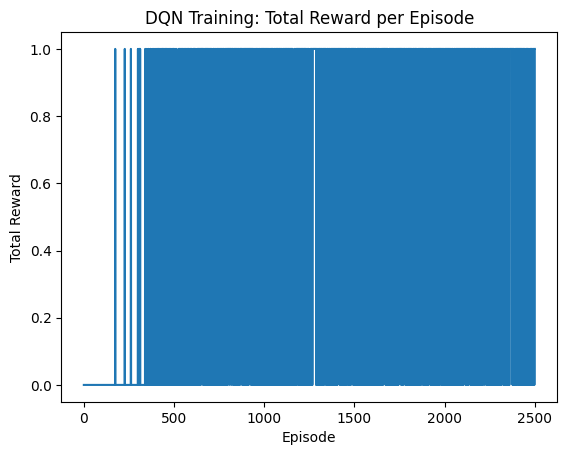

In [102]:
plt.plot(hist)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training: Total Reward per Episode')
plt.show()

In [103]:
env = gym.make('FrozenLake-v1', render_mode="human")
test(agent, env, episodes=10, max_timesteps=100)

Episode 1/10 finished with total reward: 0.0
Episode 2/10 finished with total reward: 0.0
Episode 3/10 finished with total reward: 0.0
Episode 4/10 finished with total reward: 0.0
Episode 5/10 finished with total reward: 0.0
Episode 6/10 finished with total reward: 0.0
Episode 7/10 finished with total reward: 0.0
Episode 8/10 finished with total reward: 0.0
Episode 9/10 finished with total reward: 0.0
Episode 10/10 finished with total reward: 0.0


The observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
The action space: Discrete(2)


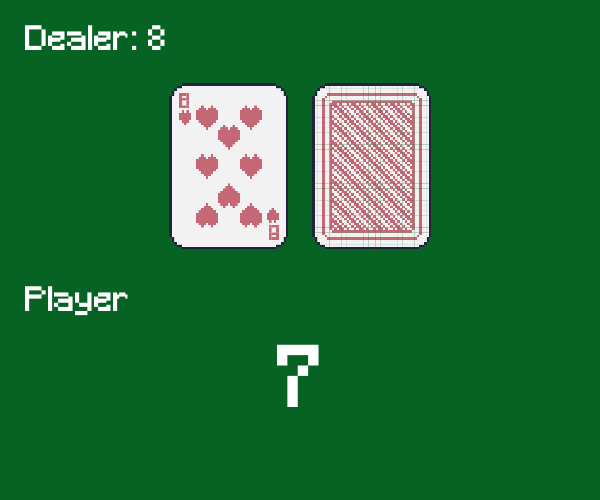

In [16]:
env = gym.make('Blackjack-v1', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") # state size
print(f"The action space: {env.action_space}") # hit or stand

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img